In [1]:
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.transforms import functional as transformF
import torchvision.utils as vutils
from torchvision.io import read_image,ImageReadMode
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from PIL import Image
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt 
import gc
from IPython.display import clear_output

In [2]:
from patchdisc import PatchDiscriminator
from UNet import Unet

In [3]:
PATH="C:\\Users\\vicin\Desktop\\PoliTo\\ML_for_CV\\CGAN"
BATCH_SIZE=16

In [4]:
class DNSDataset(Dataset):
    def __init__(self, img_dir, seg=True, norm=True, depth=True, with_previous=False, transforms=None, target_transforms=None):
        self.img_dir=img_dir
        self.imgs_depth=[]
        self.imgs_norm=[]
        self.imgs_seg=[]
        self.imgs_col=[]
        self.norm=norm
        self.seg=seg
        self.depth=depth
        self.with_previous=with_previous

        if depth:
            self.imgs_depth.extend([self.img_dir + '\\Depth\\'+i for i in os.listdir(self.img_dir+'\\Depth') if i.endswith('.png')])
        if norm:
            self.imgs_norm.extend([self.img_dir + '\\Normal\\'+i for i in os.listdir(self.img_dir+'\\Normal') if i.endswith('.png')])
        if seg:
            self.imgs_seg.extend([self.img_dir + '\\Segmentation\\'+i for i in os.listdir(self.img_dir+'\\Segmentation') if i.endswith('.png')])
        
        self.imgs_col.extend([self.img_dir + '\\Default\\'+i for i in os.listdir(self.img_dir+'\\Default') if i.endswith('.png')])
        
        self.transforms=transforms
        self.target_transforms=target_transforms
    def __getitem__(self, index) -> torch.Tensor:
        tensors=[]
        if self.with_previous:
            prev_frame=transformF.to_tensor(Image.open(self.imgs_col[0]))[0:3] #index invece che 0
            tensors.append(prev_frame)
            index=index+1

        if self.depth:
            depth=transformF.to_tensor(transformF.to_grayscale(Image.open(self.imgs_depth[index])))
            tensors.append(depth)
        if self.norm:
            norm=transformF.to_tensor(Image.open(self.imgs_norm[index]))[0:3]
            tensors.append(norm)
        if self.seg:
            seg=transformF.to_tensor(Image.open(self.imgs_seg[index]))[0:3]
            tensors.append(seg)
        col=transformF.to_tensor(Image.open(self.imgs_col[index]))[0:3]
        
        
        
        return torch.cat(tensors,0), col
        
    def __len__(self):
        if self.with_previous:
            return len(self.imgs_col)-1
        return len(self.imgs_col)

In [5]:
#Test Dataset

dataset_train=DNSDataset(PATH+'\\dataset\\Cam 1', norm=False, with_previous=True)
dataset_train_2=DNSDataset(PATH+'\\dataset\\Cam 2',  norm=False, with_previous=True)
dataset_train_3=DNSDataset(PATH+'\\dataset\\Cam 3', norm=False, with_previous=True)
dataset_train_4=DNSDataset(PATH+'\\dataset\\Cam 4', norm=False, with_previous=True)
dataset_test=DNSDataset(PATH+'\\dataset\\Cam 4', norm=False, with_previous=True)

dataset_train=ConcatDataset((dataset_train,dataset_train_2, dataset_train_3, dataset_train_4))
#dataset_train,_=random_split(dataset_train,[32,len(dataset_train)-32])
dataloader_train=DataLoader(dataset_train,BATCH_SIZE, shuffle=True)
dataloader_test=DataLoader(dataset_test,BATCH_SIZE, shuffle=True)


# plt.subplot(121)
# plt.imshow(img0_norm.permute(1,2,0))
# plt.subplot(122)
# plt.imshow(img0_depth.permute(1,2,0))

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
### TEST ###
r=torch.randn(16,100,2,2).cuda()

print(r.shape)

unet=Unet(7).cuda()
unet.apply(weights_init)


patch_discriminator=PatchDiscriminator(10,32).cuda()
patch_discriminator.apply(weights_init)

with torch.no_grad():
    r=torch.randn(1,10,256,256).cuda()
    patch_shape=list(patch_discriminator(r).shape[1:4])
    print(patch_shape)


SyntaxError: invalid syntax (3667946608.py, line 9)

In [ ]:
# optimizerDec=optim.Adam(decoder.parameters(), 0.0002, (0.5,0.999))

# enc_dec_param=list(decoder.parameters())+list(encoder.parameters())
# optimizerEncDec=optim.Adam(enc_dec_param, 0.0002, (0.5,0.999))

optimizerPatchDiscriminator=optim.Adam(patch_discriminator.parameters(), 0.0002, (0.5,0.9))
optimizerunet=optim.Adam(unet.parameters(),0.0002, (0.5,0.9) )

criterion=nn.BCELoss()
criterion_encoder=nn.SmoothL1Loss()

In [ ]:
### Train-Loop GAN ###
def optimize_GAN():
    global dataloader_train
    accuracy=0
    for (data,col) in dataloader_train:
        batch_size=len(data)
        data_gpu=data.cuda()
        col_gpu=col.cuda()

        fake_col=unet(data_gpu)

        ### Train Discriminator ### 
        patch_discriminator.zero_grad()
        unet.zero_grad()
        
        label1=torch.full([batch_size,*patch_shape], 1.).cuda() #Etichetta immagini reali

        output1=patch_discriminator(torch.cat((data_gpu, col_gpu),1)) # predizioni
        loss_discr_real=criterion(output1, label1) # cross entropy

        accuracy+=output1.round().eq(1.).sum().item()/64

        label2=torch.full([batch_size,*patch_shape], 0.).cuda()

        output2=patch_discriminator(torch.cat((data_gpu,fake_col.detach()), 1) )
        loss_discr_fake=criterion(output2,label2)

        accuracy+=output2.round().eq(0.).sum().item()/64

        
        loss_discr=loss_discr_real+loss_discr_fake
        loss_discr.backward()
        optimizerPatchDiscriminator.step()
        
        ### Train Generator ###
        
        output3=patch_discriminator(torch.cat((data_gpu,fake_col),1))
        errDec = criterion(output3, label1)

        errDec.backward()
        optimizerunet.step()

        fake_col.cpu()
        data_gpu.cpu()
        col_gpu.cpu()
        gc.collect()
        torch.cuda.empty_cache()
        
    return accuracy/len(dataloader_train.dataset), fake_col[0], data_gpu[0].split([1,3,3])[0]

```def optimize_encoder_decoder():
    global encoder, decoder, discriminator, dataloader_train
    accuracy=0
    for (data,seg) in dataloader_train:
        batch_size=data.shape[0]
        data_gpu=data.cuda()
        seg_gpu=seg.cuda()

        latent_batch=encoder(seg_gpu)

        fake_data=decoder(latent_batch)

        ### Train Discriminator ### 
        discriminator.zero_grad()
        decoder.zero_grad()
        encoder.zero_grad()
        

        label1=torch.full((batch_size,), 1.).cuda() #Etichetta immagini reali
        output1=discriminator(torch.cat([data_gpu,seg_gpu], dim=1)).view(-1) # predizioni
        errDisc_real=criterion(output1, label1) # cross entropy

        accuracy+=output1.eq(1.).sum().item()

        label2=torch.full((batch_size,), 0.).cuda()
        output2=discriminator(torch.cat([fake_data.detach(),seg_gpu], dim=1)).view(-1)
        errDisc_fake=criterion(output2,label2)

        accuracy+=output1.eq(0.).sum().item()

        
        errDisc=errDisc_real+errDisc_fake
        errDisc.backward()
        optimizerDisc.step()
        
        ### Train Decoder ###
        
        
        # errDec=criterion_encoder(fake_data, data_gpu)

        # errDec.backward()
        # optimizerEncDec.step()

        output3=discriminator(torch.cat([fake_data, seg_gpu], dim=1)).view(-1)
        errGen=criterion(output3, label1)
        errGen.backward()
        optimizerEncDec.step()
        fake_data.cpu()
        data_gpu.cpu()
        seg_gpu.cpu()
        gc.collect()
        torch.cuda.empty_cache()
        
    return accuracy/len(dataloader_train.dataset), fake_data[0], seg[0]```
    

In [ ]:

### Train Loop ###
epochs=1500
start_epoch=0
if "neverStreets" in os.listdir("./"):
  print("Loading...")
  try:
    state = torch.load("./neverStreets")
    if state:
      patch_discriminator.load_state_dict(state["Discriminator"])
      unet.load_state_dict(state["Generator"])
      optimizerPatchDiscriminator.load_state_dict(state["optimizerDiscriminator_state_dict"])
      optimizerunet.load_state_dict(state["optimizerUNet_state_dict"])
      start_epoch=state["epoch"]
  except:
    print("Error in load")



for i in range(start_epoch, epochs):
    print("Epoch ",i)
    accuracy, fake_col, col=optimize_GAN()
    
    clear_output(wait=True)
    print("Saving...")
    torch.save({"Discriminator":patch_discriminator.state_dict(),
    "optimizerDiscriminator_state_dict":optimizerPatchDiscriminator.state_dict(),
    "Generator":unet.state_dict(),
    "optimizerUNet_state_dict":optimizerunet.state_dict(),
    "epoch":i},
    "./neverStreets")
    print(accuracy)
    
    plt.subplot(121)
    plt.imshow(fake_col.cpu().detach().permute([1,2,0]))
    plt.subplot(122)
    plt.imshow(col.cpu().detach().permute([4,5,3]))
    plt.show()

Loading...
Epoch  3


KeyboardInterrupt: 

Loading...
32


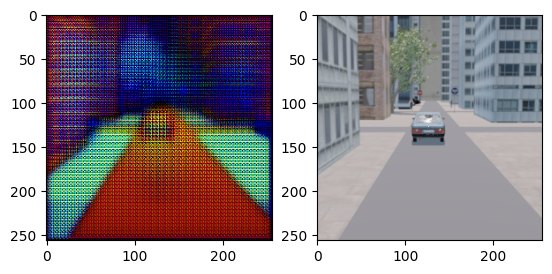

In [ ]:
import random
generator=Unet(7).cuda()

if "neverStreets" in os.listdir("./"):
  print("Loading...")
  try:
    state = torch.load("./neverStreets")
    if state:
      generator.load_state_dict(state["Generator"])
  except:
    print("Error in load")


print(len(dataloader_test))
data,col=next(iter(dataloader_test))
#fake_data=decoder(torch.randn([16,100,1,1], device='cuda'))
r=random.randint(0, len(data)-1)
fake_col=generator(data.cuda())
to_image=transforms.ToPILImage()
plt.subplot(121)
plt.imshow(to_image(fake_col[r].clip(0,1).cpu()))
plt.subplot(122)
plt.imshow(to_image(col[r].clip(0,1).cpu()))